# Vectorized MVN sampling with event-dependent covariance

We aim to obtain multivariate normal sample given covariance matrix for each event and sample of standard multivariate normal distribution

In [5]:
import jax.random as rjax
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [95]:
rng = rjax.PRNGKey(7)

In [15]:
import itertools

## Test 1. Constant covariance matrix

In [26]:
mean = np.zeros(3)
cov = np.array([
    [1.0, 0.5, 0.9],
    [0.5, 2.0, -0.8],
    [0.9, -0.8, 3.0]
])

In [27]:
samp1 = rjax.multivariate_normal(rng, mean, cov, (5000,))

In [28]:
samp1.shape

(5000, 3)

In [31]:
def plot_data(ax, data):
    x, y, z = [data[:, i] for i in range(3)]
    for i, j in itertools.product(range(3), range(3)):
        ax[i, j].grid()
        ax[i, j].minorticks_on()
        ax[i, j].grid(which='minor', linestyle=':')
        ax[i, j].set_xlim((-5, 5))
        if i == j:
            ax[i, j].hist(data[:,i], bins=100, histtype='step')
        else:
            ax[i, j].scatter(data[:,i], data[:,j], s=0.4)
            ax[i, j].set_ylim((-5, 5))

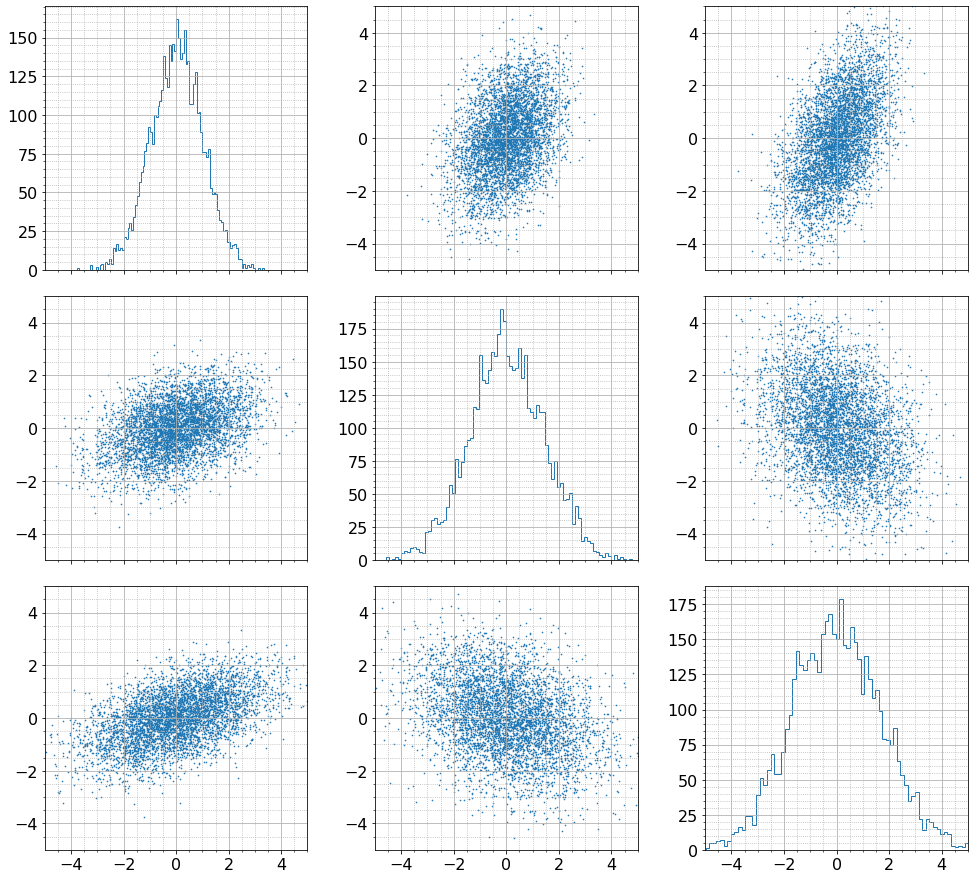

In [62]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14, 12.5), sharex=True)
plot_data(ax, samp1)
fig.tight_layout()

In [33]:
samp2 = rjax.multivariate_normal(rng, np.zeros(3), np.diag(np.ones(3)), (5000,))

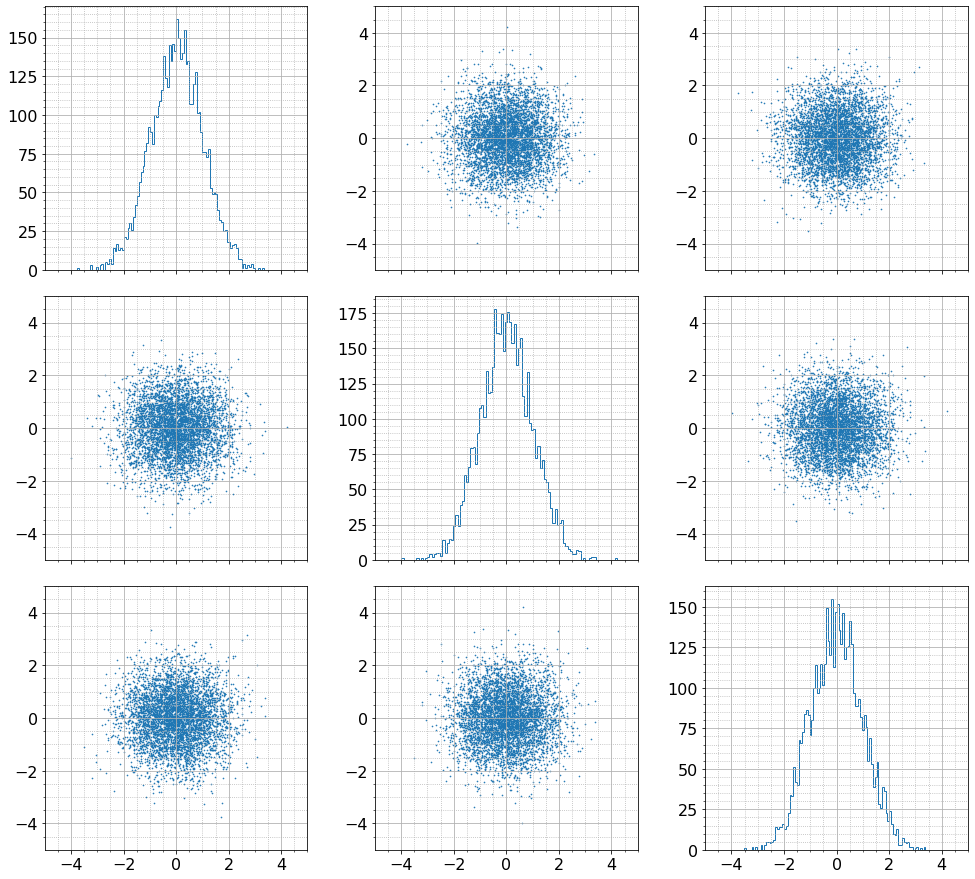

In [61]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14, 12.5), sharex=True)
plot_data(ax, samp2)
fig.tight_layout()

Transform sample using the Cholesky decomposition

In [37]:
L = np.linalg.cholesky(cov)
L

DeviceArray([[ 1.       ,  0.       ,  0.       ],
             [ 0.5      ,  1.3228756,  0.       ],
             [ 0.9      , -0.9449112,  1.1389219]], dtype=float32)

In [41]:
samp2x = (L @ samp2.T).T
samp2x.shape

(5000, 3)

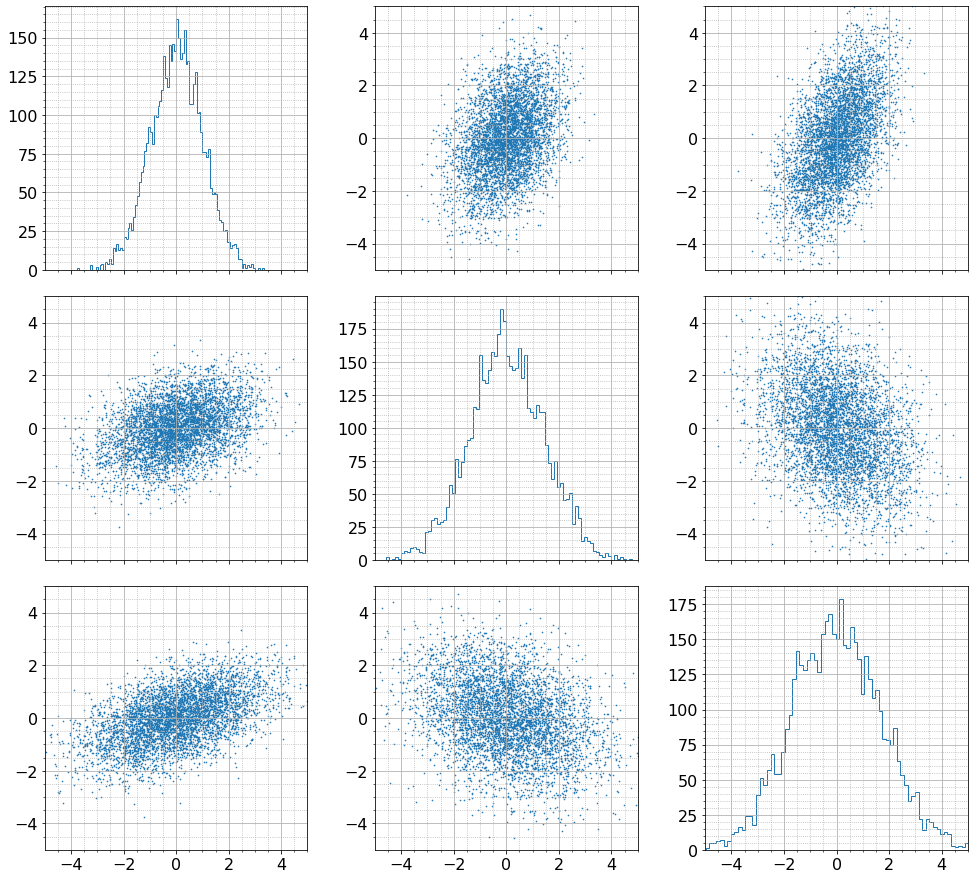

In [60]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14, 12.5), sharex=True)
plot_data(ax, samp2x)
fig.tight_layout()

In [48]:
np.cov(samp2x.T)

DeviceArray([[ 0.97266406,  0.4980199 ,  0.86742395],
             [ 0.4980199 ,  1.992615  , -0.79523474],
             [ 0.86742395, -0.79523474,  2.9415658 ]], dtype=float32)

In [50]:
np.cov(samp1.T)

DeviceArray([[ 0.97266406,  0.4980199 ,  0.86742395],
             [ 0.4980199 ,  1.992615  , -0.79523474],
             [ 0.86742395, -0.79523474,  2.9415658 ]], dtype=float32)

In [56]:
np.allclose(np.cov(samp2.T), np.cov(samp1.T))

DeviceArray(False, dtype=bool)

In [57]:
np.allclose(np.cov(samp2x.T), np.cov(samp1.T))

DeviceArray(True, dtype=bool)

## Test 2. Event-dependent covariance

In [117]:
def covgen(rng, N):
    base = np.array([
        [1.0, 0.5, 0.6],
        [0.5, 2.0, -0.6],
        [0.6, -0.6, 3.0]
    ])
    noise = rjax.normal(rng, (N, 3, 3))
    for n in noise:
        yield base + 0.04*n

In [118]:
%%time
N = 5000
mean = np.zeros(3)
covv = np.stack([cov for cov in covgen(rng, N)], axis=0)
covv.shape

CPU times: user 2.53 s, sys: 217 ms, total: 2.75 s
Wall time: 2.19 s


(5000, 3, 3)

In [119]:
Lv = np.linalg.cholesky(covv)
Lv.shape

(5000, 3, 3)

In [120]:
Lv[0]

DeviceArray([[ 0.9900787 ,  0.        ,  0.        ],
             [ 0.4919508 ,  1.3125678 ,  0.        ],
             [ 0.5841693 , -0.66197664,  1.4819266 ]], dtype=float32)

Event-dependent generation with Cholesky decomposition:

In [121]:
%%timeit
samp0 = rjax.multivariate_normal(rng, np.zeros(3), np.diag(np.ones(3)), (N,))
Lv = np.linalg.cholesky(covv)
samp2xv = np.einsum('ijk, ik -> ij', Lv, samp0)
samp2xv.shape

24.5 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
np.cov(samp2xv.T)

DeviceArray([[ 1.0104464 ,  0.50362915,  0.5515383 ],
             [ 0.50362915,  2.0009272 , -0.58796495],
             [ 0.5515383 , -0.58796495,  2.976665  ]], dtype=float32)

Not vectorized event-dependent generation (doesn't work properly since the same key is used at each iteration):

In [123]:
%%timeit
samp3 = np.stack([rjax.multivariate_normal(rng, mean, c) for c in covv], axis=0)
samp3.shape

2.85 s ± 569 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
np.cov(samp3.T)

DeviceArray([[ 2.2741916e-13,  2.8427395e-14, -2.8427395e-14],
             [ 2.8427395e-14,  3.5534243e-15, -3.5534243e-15],
             [-2.8427395e-14, -3.5534243e-15,  3.5534243e-15]],            dtype=float32)

In [125]:
covv[7]

DeviceArray([[ 1.0115008 ,  0.41818464,  0.6678268 ],
             [ 0.44579622,  1.9453701 , -0.55932033],
             [ 0.68479556, -0.57259035,  2.938804  ]], dtype=float32)

In [126]:
covv[77]

DeviceArray([[ 0.9705745 ,  0.5745339 ,  0.609516  ],
             [ 0.48335272,  2.0220792 , -0.6410775 ],
             [ 0.6138682 , -0.6110675 ,  2.9677022 ]], dtype=float32)